
Run 1: lr=0.001, batch=32, weight_decay=0.0
  -> best_val_acc=95.87% | best_val_loss=0.1086 | time=1085.1s

Run 2: lr=0.001, batch=32, weight_decay=0.0001
  -> best_val_acc=94.21% | best_val_loss=0.1495 | time=1040.0s

Run 3: lr=0.001, batch=64, weight_decay=0.0
  -> best_val_acc=92.51% | best_val_loss=0.1854 | time=988.5s

Run 4: lr=0.001, batch=64, weight_decay=0.0001
  -> best_val_acc=92.85% | best_val_loss=0.1702 | time=952.8s

Run 5: lr=0.0003, batch=32, weight_decay=0.0
  -> best_val_acc=93.52% | best_val_loss=0.1769 | time=966.6s

Run 6: lr=0.0003, batch=32, weight_decay=0.0001
  -> best_val_acc=92.05% | best_val_loss=0.1967 | time=968.6s

Run 7: lr=0.0003, batch=64, weight_decay=0.0
  -> best_val_acc=90.35% | best_val_loss=0.2521 | time=957.2s

Run 8: lr=0.0003, batch=64, weight_decay=0.0001
  -> best_val_acc=90.72% | best_val_loss=0.2324 | time=957.0s

Run 9: lr=0.0001, batch=32, weight_decay=0.0
  -> best_val_acc=88.69% | best_val_loss=0.2740 | time=962.8s

Run 10: lr=0.0001

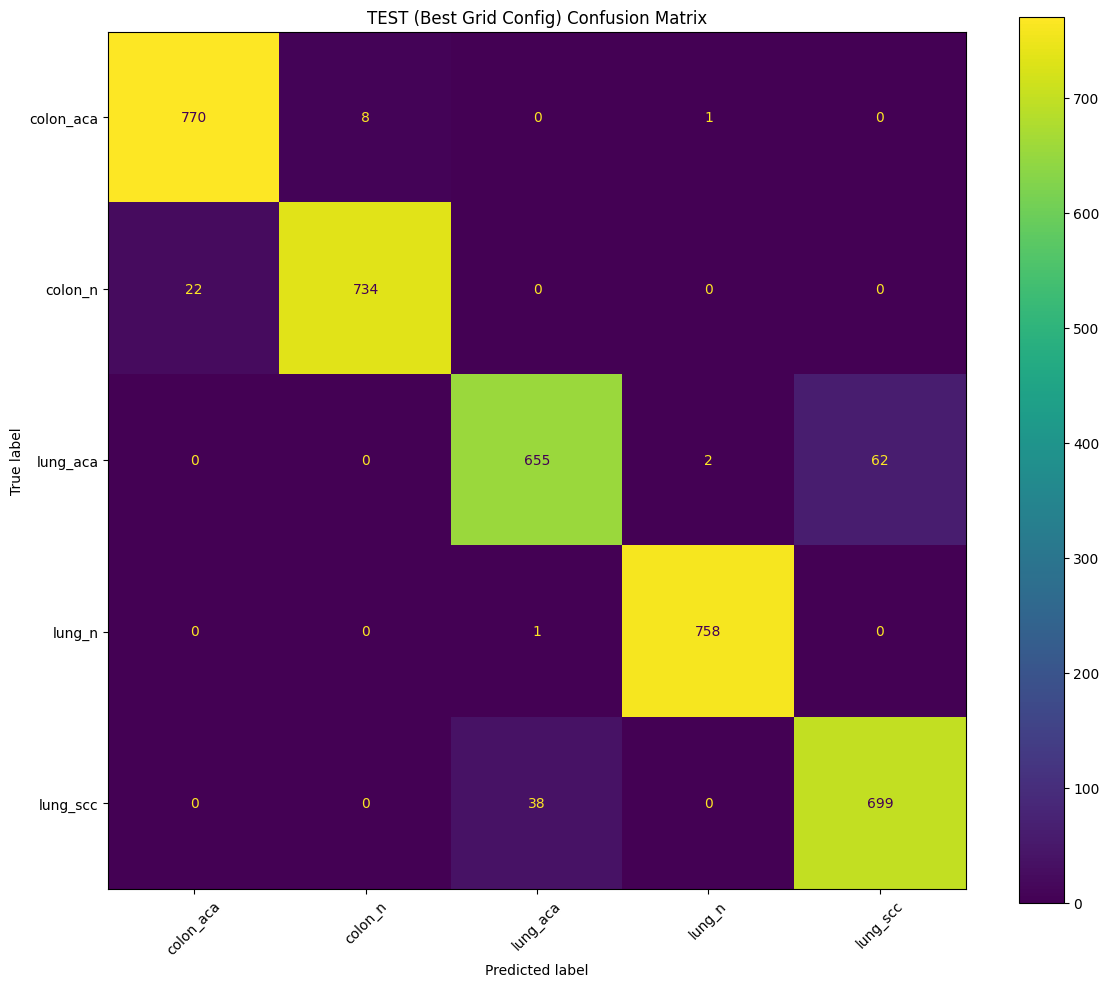

In [ ]:
import os, time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from PIL import Image

import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_fscore_support
)

# 
class CancerCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

#  Dataset 
class CancerDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_per_class=5000):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []

        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            if os.path.exists(class_dir):
                images = [f for f in os.listdir(class_dir)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff'))]
                for img_name in images[:max_per_class]:
                    self.samples.append((os.path.join(class_dir, img_name), self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label

#  split loaders 
def make_split_loaders(data_dir="lungcolon", batch_size=32, seed=42):
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]),
    ])

    dataset = CancerDataset(root_dir=data_dir, transform=transform, max_per_class=5000)
    class_names = dataset.classes

    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_ds, val_ds, test_ds = random_split(
        dataset, [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(seed)
    )

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0)

    return class_names, train_loader, val_loader, test_loader

#Evaluate metrics helper
def predict_all(model, loader, device):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            logits = model(images)
            preds = logits.argmax(dim=1)
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(preds.cpu().tolist())
    return y_true, y_pred

def print_metrics_and_confusion(y_true, y_pred, class_names, title="TEST"):
    acc = accuracy_score(y_true, y_pred)

    # macro averages are best for multi-class fairness
    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(
        y_true, y_pred, average="macro", zero_division=0
    )

    print(f"\n{title} METRICS ")
    print(f"Accuracy: {acc*100:.2f}%")
    print(f"Macro Precision: {prec_m*100:.2f}%")
    print(f"Macro Recall:    {rec_m*100:.2f}%")
    print(f"Macro F1-score:  {f1_m*100:.2f}%")

    print("\n Classification Report \n")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4, zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    fig, ax = plt.subplots(figsize=(12, 10))
    disp.plot(ax=ax, xticks_rotation=45, values_format="d")
    ax.set_title(f"{title} Confusion Matrix")
    plt.tight_layout()
    plt.show()

    return {"accuracy": acc, "macro_precision": prec_m, "macro_recall": rec_m, "macro_f1": f1_m}, cm

# Train one config and save best-by-val checkpoint 
def run_one_config(lr, batch_size, weight_decay, epochs=3, seed=42, data_dir="lungcolon", save_dir="grid_ckpts"):
    os.makedirs(save_dir, exist_ok=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    class_names, train_loader, val_loader, _ = make_split_loaders(
        data_dir=data_dir, batch_size=batch_size, seed=seed
    )

    model = CancerCNN(num_classes=len(class_names)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    best_val_acc = 0.0
    best_val_loss = float("inf")
    best_path = os.path.join(save_dir, f"best_lr{lr}_bs{batch_size}_wd{weight_decay}.pth")

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

        # validation
        y_true, y_pred = predict_all(model, val_loader, device)
        val_acc = accuracy_score(y_true, y_pred)

        # compute val loss (optional, but useful)
        model.eval()
        val_loss_sum = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                logits = model(images)
                val_loss_sum += criterion(logits, labels).item()
        val_loss = val_loss_sum / len(val_loader)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            torch.save({
                "model_state_dict": model.state_dict(),
                "lr": lr,
                "batch_size": batch_size,
                "weight_decay": weight_decay,
                "seed": seed,
                "epoch": epoch + 1,
                "best_val_acc": best_val_acc,
                "best_val_loss": best_val_loss,
                "classes": class_names
            }, best_path)

    return best_val_acc, best_val_loss, best_path

#  GRID SEARCH: pick best by val, then evaluate on TEST
def grid_search(data_dir="lungcolon", seed=42):
    learning_rates = [1e-3, 3e-4, 1e-4]
    batch_sizes = [32, 64]
    weight_decays = [0.0, 1e-4]
    epochs_per_run = 3

    results = []
    best = None

    run_id = 0
    for lr in learning_rates:
        for bs in batch_sizes:
            for wd in weight_decays:
                run_id += 1
                print(f"\nRun {run_id}: lr={lr}, batch={bs}, weight_decay={wd}")
                t0 = time.time()

                best_val_acc, best_val_loss, ckpt_path = run_one_config(
                    lr=lr, batch_size=bs, weight_decay=wd,
                    epochs=epochs_per_run, seed=seed, data_dir=data_dir
                )

                dt = time.time() - t0
                row = {
                    "run": run_id,
                    "lr": lr,
                    "batch": bs,
                    "weight_decay": wd,
                    "best_val_acc": best_val_acc,
                    "best_val_loss": best_val_loss,
                    "ckpt_path": ckpt_path,
                    "time_s": dt
                }
                results.append(row)

                if best is None or best_val_acc > best["best_val_acc"]:
                    best = row

                print(f"  -> best_val_acc={best_val_acc*100:.2f}% | best_val_loss={best_val_loss:.4f} | time={dt:.1f}s")

    # Show sorted results
    results_sorted = sorted(results, key=lambda x: x["best_val_acc"], reverse=True)
    print("\n GRID RESULTS ")
    for r in results_sorted:
        print(f"Run {r['run']:>2} | val_acc={r['best_val_acc']*100:6.2f}% | "
              f"lr={r['lr']} bs={r['batch']} wd={r['weight_decay']} | "
              f"val_loss={r['best_val_loss']:.4f} | {r['time_s']:.1f}s")

    print("\nBEST (by validation accuracy) ")
    print(best)

    # 
    print("\nEVALUATION")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ckpt = torch.load(best["ckpt_path"], map_location=device)

    model = CancerCNN(num_classes=len(ckpt["classes"])).to(device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()

    # Use same split and batch size as best config
    class_names, _, _, test_loader = make_split_loaders(
        data_dir=data_dir,
        batch_size=best["batch"],
        seed=seed
    )

    y_true, y_pred = predict_all(model, test_loader, device)
    metrics, cm = print_metrics_and_confusion(y_true, y_pred, class_names, title="TEST (Best Grid Config)")

    return best, results_sorted, metrics, cm

if __name__ == "__main__":
    best, results, metrics, cm = grid_search(data_dir="lungcolon", seed=42)

